In [1]:
# J. Ryu, Electron Microscopy and Spectroscopy Lab., Seoul National University
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hys
import tkinter.filedialog as tkf
import ipywidgets as pyw
from tabulate import tabulate
from sklearn.cluster import DBSCAN

In [ ]:
%matplotlib inline

In [3]:
num_split = 3
adr = []
num_adr = []
for i in range(num_split):
    temp = tkf.askopenfilenames()
    num_adr.append(len(temp))
    adr.append(temp)
print(num_adr)
num_img = np.max(num_adr)

[1, 1, 1]


In [11]:
#camera_length = 1.1462 # m
#pixel_size = 150E-6 # m
#mrad_per_pixel = np.arctan(pixel_size / camera_length) * 1000# mrad
mrad_per_pixel = 0.27045890769499215 # mrad
print(mrad_per_pixel)
rel_lmb = 0.00197 # nm, relativistic wavelength for 300 kV
k_per_pixel = np.tan(mrad_per_pixel/1000) / rel_lmb# 1/nm
print(k_per_pixel)
r_per_pixel = 0.400 # nm

s_dim = 60
cb_rad = 20
k_list = np.arange(s_dim)*k_per_pixel
print(k_list)

0.27045890769499215
0.13728878897944344
[0.         0.13728879 0.27457758 0.41186637 0.54915516 0.68644394
 0.82373273 0.96102152 1.09831031 1.2355991  1.37288789 1.51017668
 1.64746547 1.78475426 1.92204305 2.05933183 2.19662062 2.33390941
 2.4711982  2.60848699 2.74577578 2.88306457 3.02035336 3.15764215
 3.29493094 3.43221972 3.56950851 3.7067973  3.84408609 3.98137488
 4.11866367 4.25595246 4.39324125 4.53053004 4.66781883 4.80510761
 4.9423964  5.07968519 5.21697398 5.35426277 5.49155156 5.62884035
 5.76612914 5.90341793 6.04070672 6.1779955  6.31528429 6.45257308
 6.58986187 6.72715066 6.86443945 7.00172824 7.13901703 7.27630582
 7.4135946  7.55088339 7.68817218 7.82546097 7.96274976 8.10003855]


In [12]:
data_by_split = []
data_flat = []
data_flat_by_split = []
data_shape = []
for i in range(num_split):
    temp = []
    temp_shape = []
    temp_flat = []
    for path in adr[i]:
        print(path)
        tmp = hys.load(path).data
        print(tmp.shape)
        if len(np.where(tmp[0, 0] == 0.0)[0]) != cb_rad:
            tmp = np.insert(tmp, 0, 0, axis=2)        
        
        tmp = tmp[:, :, :s_dim]
        print(tmp.shape)
        temp.append(tmp)
        temp_shape.append(tmp.shape)
        temp_flat.extend(tmp.reshape(-1, tmp.shape[2]).tolist())
        data_flat.extend(tmp.reshape(-1, tmp.shape[2]).tolist())
    data_by_split.append(temp)
    data_shape.append(temp_shape)
    data_flat_by_split.append(temp_flat)

D:/repository/data_repository/4D/20201220_IGZO_TZ/acquisition_1/cropped_radial_var_radial.hdf5
(79, 196, 89)
(79, 196, 60)
D:/repository/data_repository/4D/20201220_IGZO_TZ/acquisition_2/cropped_radial_var_radial.hdf5
(73, 194, 89)
(73, 194, 60)
D:/repository/data_repository/4D/20201220_IGZO_TZ/acquisition_3/cropped_radial_var_radial.hdf5
(69, 191, 89)
(69, 191, 60)


In [13]:
data_flat = np.asarray(data_flat)
print(data_flat.shape)
data_shape = np.asarray(data_shape)
print(data_shape.shape)
print(np.unique(data_shape[:, :, 2]))
s_dim = np.min(data_shape[:, :, 2])
print(s_dim)

(42825, 60)
(3, 1, 3)
[60]
60


In [14]:
radial_var_sum = []
for arr in data_by_split:
    temp = []
    for img in arr:
        temp.append(np.mean(img, axis=(0, 1)))
    radial_var_sum.append(temp)

In [15]:
color_rep = ["black", "gray", "green", "red", "orange", "blue", "purple", "hotpink", "lime", "cyan", "magenta", "lightgray", "peru", "springgreen", "deepskyblue", "yellow"]
print(len(color_rep))

16


In [ ]:
%matplotlib inline

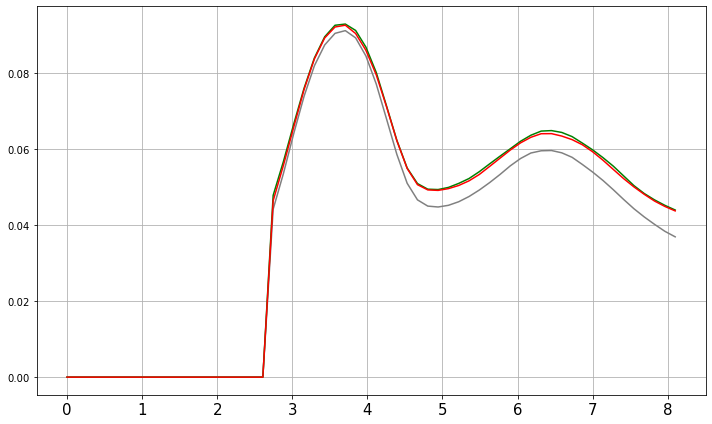

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.tick_params(axis="x", labelsize=15)
for i in range(num_split):
    for line in radial_var_sum[i]:
        ax.plot(k_list, line, color=color_rep[i+1], linestyle="-", label="split %d"%(i+1))
ax.grid()
#fig.legend(fontsize="xx-large")
fig.tight_layout()
plt.show()

0.09110522986378904
0.09283368279778029
0.09253035712441597


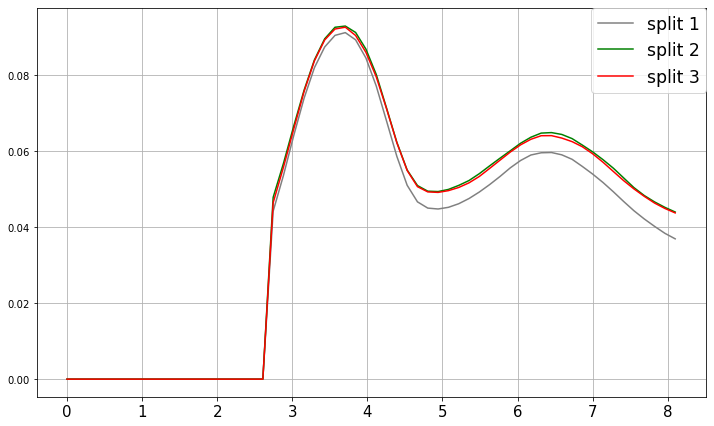

In [17]:
radial_var_split = []
for i in range(num_split):
    radial_var_split.append(np.mean(data_flat_by_split[i], axis=0))
    
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.tick_params(axis="x", labelsize=15)
for i in range(num_split):
    ax.plot(k_list, radial_var_split[i], color=color_rep[i+1], linestyle="-", label="split %d"%(i+1))
    print(np.max(radial_var_split[i]))
ax.grid()
fig.legend(fontsize="xx-large")
fig.tight_layout()
plt.show()

In [18]:
# assume the shape of clusters is circle

def cluster_size(img):
    label = np.unique(img)
    label = label[label != -1]
    #print(label)
    cluster_size = []
    for i in label:
        cluster_size.append(len(np.where(img==i)[0]))
    cluster_size = np.sort(cluster_size)
    #print(cluster_size)

    largest = 2*np.sqrt(cluster_size[-1]/np.pi)
    smallest = 2*np.sqrt(cluster_size[0]/np.pi)
    avg = 2*np.sqrt(np.mean(cluster_size)/np.pi)
    avg_peri = 2*np.sqrt(np.mean(cluster_size)*np.pi)
    
    return avg, avg_peri, largest, smallest

In [19]:
%matplotlib qt
binsize = 2000
fig1, ax1 = plt.subplots(1, 2, figsize=(15, 6))
fig2, ax2 = plt.subplots(num_split, num_img, figsize=(15, 15))
selected_img = []

def var_selector(k1, k2, p1, p2):
    
    v1 = np.percentile(data_flat[:, k1:(k2+1)], p1)
    v2 = np.percentile(data_flat[:, k1:(k2+1)], p2)
    
    print("left k = %f"%(k1*k_per_pixel))
    print("right k = %f"%(k2*k_per_pixel))
    print("left variance = %f"%v1)
    print("right variance = %f"%v2)
    
    ax1[0].cla()
    ax1[1].cla()
    selected_img.clear()
    for i in range(num_split):
        ax1[0].plot(radial_var_split[i], color=color_rep[i+1], linestyle="-", label="split %d"%(i+1))
        ax1[1].hist(np.array(data_flat_by_split[i])[:, k1:(k2+1)].flatten(), bins=binsize, 
                    color=color_rep[i+1], alpha=0.5, label="split %d"%(i+1), density=True, histtype="step")
        for j in range(num_img):
            img = np.array(data_by_split[i][j])[:, :, k1:(k2+1)]
            img[np.where(img < v1)] = 0
            img[np.where(img > v2)] = 0
            img[np.where(img != 0)] = 1
            bool_img = np.sum(img, axis=2)
            bool_img = np.divide(bool_img, np.where(bool_img!=0, bool_img, 1))
            selected_img.append(bool_img)
            ind = num_img*i+j
            #print(ind)
            ax2.flat[ind].imshow(bool_img, cmap="afmhot")
            ax2.flat[ind].axis("off")
            ax2.flat[ind].set_title("%.2f %%"%(np.sum(bool_img)*100/(img.shape[0]*img.shape[1])))
                
    ax1[0].fill_between([k1, k2], np.max(radial_var_split), alpha=0.5, color="orange")
    ax1[0].grid()
    ax1[0].legend(fontsize="xx-large")
    ax1[1].fill_between([v1, v2], ax1[1].get_ylim()[1], alpha=0.5, color="orange")
    ax1[1].grid()
    ax1[1].legend(fontsize="xx-large")
    
    fig1.canvas.draw()
    fig2.canvas.draw()
    fig1.tight_layout()
    fig2.tight_layout()
    
st = {"description_width": "initial"}
k1_widget = pyw.IntText(value=28, description="left of k-range", style=st)
k2_widget = pyw.IntText(value=28, description="right of k-range", style=st)
p1_widget = pyw.FloatText(value=90.0, description="left percentile of variance range", style=st)
p2_widget = pyw.FloatText(value=99.999, description="right percentile of variance range", style=st)
pyw.interact(var_selector, k1=k1_widget, k2=k2_widget, p1=p1_widget, p2=p2_widget)
plt.show()

interactive(children=(IntText(value=28, description='left of k-range', style=DescriptionStyle(description_widt…

In [20]:
k_range = [k1_widget.value, k2_widget.value]
print(k_range)
v_range = [np.percentile(data_flat, p1_widget.value), np.percentile(data_flat, p2_widget.value)]
print(v_range)

[26, 27]
[0.07221452568441387, 0.3701444577008192]


In [21]:
%matplotlib qt
#fig3, ax3 = plt.subplots(1, 3, figsize=(20, 10))
fig3, ax3 = plt.subplots(1, 2, figsize=(5, 10))
row_label = ["area (%)", "# of clusters (per 10000 nm^2)", "mean size (nm)", "largest size (nm)", "smallest size (nm)"]

def selector(m, e, split, n_img):
    db = DBSCAN(eps=e, min_samples=m)
    ind = num_img*(split-1)+n_img-1

    ax3[0].cla()
    ax3[1].cla()
    #ax3[2].cla()
    
    ax3[0].imshow(selected_img[ind], cmap="afmhot")
    ax3[0].set_title("%.2f %%"%(np.sum(selected_img[ind])*100/(selected_img[ind].shape[0]*selected_img[ind].shape[1])))
    ax3[0].axis("off")  
    
    sel_coor = np.nonzero(selected_img[ind])
    X = np.stack((sel_coor[0], sel_coor[1]), axis=1)
    db.fit(X)
    label = db.labels_
    img_tmp = np.zeros_like(selected_img[ind])
    img_tmp += -1
    img_tmp[X[:, 0], X[:, 1]] = label
    bool_img = np.where(img_tmp<0, img_tmp, 1)
    bool_img = np.where(bool_img>-1, bool_img, 0)
    #ax3[1].set_title("split %d, image %d, epsilon=%.1f, min_#_of_samples=%d"%(split, n_img, e, m), fontsize=15)
    ax3[1].imshow(bool_img, cmap="afmhot")
    ax3[1].axis("off")
    
    area = np.around(100 * np.sum(bool_img) / (img_tmp.shape[0]*img_tmp.shape[1]), decimals=2)
    print("area of the roi = %.2f"%(img_tmp.shape[0]*img_tmp.shape[1]*r_per_pixel**2))
    per_10000sqnm = 10000 / (img_tmp.shape[0]*img_tmp.shape[1]*r_per_pixel**2)
    n_cluster = np.around((len(np.unique(label)) - 1) * per_10000sqnm, decimals=0)
    if n_cluster != 0:
        avg, avg_peri, largest, smallest = cluster_size(img_tmp)
        avg = np.around(avg*r_per_pixel, decimals=2)
        avg_peri = np.around(avg_peri*r_per_pixel, decimals=2)
        largest = np.around(largest*r_per_pixel, decimals=2)
        smallest = np.around(smallest*r_per_pixel, decimals=2)
        table_vals = [[area], [n_cluster], [avg], [largest], [smallest]]
        print("----------------------------------------")
        print("split %d, image %d"%(split, n_img))
        print("epsilon=%.1f, minimum # of samples=%d"%(e, m))
        print(tabulate([["area (%)", area], ["# of cluster (per 10000 nm^2)", n_cluster], ["mean perimeter", avg_peri], 
                        ["mean size", avg], ["largest size", largest], ["smallest size", smallest]]))
        #table = ax3[2].table(cellText=table_vals, rowLabels=row_label, loc="center", 
        #                     rowLoc="center", cellLoc="center", colWidths=[0.1]*3)
        #table.scale(3, 8)
        #table.auto_set_font_size(False)
        #table.set_fontsize(15)
        
    else:
        print("----------------------------------------")
        print("there is no clusters")


    #ax3[2].axis("off")
    fig3.tight_layout()
    
st = {"description_width": "initial"}
min_widget = pyw.IntText(value=4, description="minimum # of cluster pixels", style=st)
eps_widget = pyw.FloatText(value=1.5, description="epsilon: ")
split_widget = pyw.Dropdown(options=np.arange(num_split)+1, value = 1, description="split: ", style=st)
n_img_widget = pyw.Dropdown(options=np.arange(np.max(num_adr))+1, value = 1, description="image: ", style=st)

pyw.interact(selector, m=min_widget, e=eps_widget, split=split_widget, n_img=n_img_widget)
fig3.show()

interactive(children=(IntText(value=4, description='minimum # of cluster pixels', style=DescriptionStyle(descr…

In [ ]:
%matplotlib qt
binsize = 2000
#fig3, ax3 = plt.subplots(1, 5, figsize=(20, 6))
fig3, ax3 = plt.subplots(1, 4, figsize=(20, 6))
row_label = ["area (%)", "# of clusters (per 10000 nm^2)", "mean size (nm)", "largest size (nm)", "smallest size (nm)"]

def selector(k1, k2, p1, p2, m, e, split, n_img):
    db = DBSCAN(eps=e, min_samples=m)
    ind = num_img*(split-1)+n_img-1

    ax3[0].cla()
    ax3[1].cla()
    ax3[2].cla()
    ax3[3].cla()
    #ax3[4].cla()
    
    for i in range(num_split):
        ax3[0].plot(radial_var_split[i], color=color_rep[i+1], linestyle="-", label="split %d"%(i+1))
    
    flat = np.array(data_by_split[split-1][n_img-1])[:, :, k1:(k2+1)].flatten()
    ax3[1].hist(flat, bins=binsize, color=color_rep[split], label="split %d"%(split), density=True, histtype="step")
        
    print("left k = %f"%(k1*k_per_pixel))
    print("right k = %f"%(k2*k_per_pixel))
    
    v1 = np.percentile(flat, p1)
    v2 = np.percentile(flat, p2)
    print("left variance = %f"%v1)
    print("right variance = %f"%v2)
    
    ax3[0].fill_between([k1, k2], np.max(radial_var_split), alpha=0.5, color="orange")
    ax3[0].grid()
    #ax3[0].legend(fontsize="xx-large")
    ax3[1].fill_between([v1, v2], ax3[1].get_ylim()[1], alpha=0.5, color="orange")
    ax3[1].grid()    
    
    img = np.array(data_by_split[split-1][n_img-1])[:, :, k1:(k2+1)]
    img[np.where(img < v1)] = 0
    img[np.where(img > v2)] = 0
    img[np.where(img != 0)] = 1
    bool_img = np.sum(img, axis=2)
    bool_img = np.divide(bool_img, np.where(bool_img!=0, bool_img, 1))
    ax3[2].imshow(bool_img, cmap="afmhot")
    ax3[2].axis("off")
    ax3[2].set_title("%.2f %%"%(np.sum(bool_img)*100/(img.shape[0]*img.shape[1])))
        
    sel_coor = np.nonzero(bool_img)
    X = np.stack((sel_coor[0], sel_coor[1]), axis=1)
    db.fit(X)
    label = db.labels_
    img_tmp = np.zeros_like(bool_img)
    img_tmp += -1
    img_tmp[X[:, 0], X[:, 1]] = label
    cluster_img = np.where(img_tmp<0, img_tmp, 1)
    cluster_img = np.where(cluster_img>-1, bool_img, 0)
    #ax3[3].set_title("split %d, image %d, epsilon=%.1f, min_#_of_samples=%d"%(split, n_img, e, m), fontsize=10)
    ax3[3].imshow(cluster_img, cmap="afmhot")
    ax3[3].axis("off")
    
    area = np.around(100 * np.sum(cluster_img) / (img_tmp.shape[0]*img_tmp.shape[1]), decimals=2)
    per_10000sqnm = 10000 / (img_tmp.shape[0]*img_tmp.shape[1]*r_per_pixel**2)
    n_cluster = np.around((len(np.unique(label)) - 1) * per_10000sqnm, decimals=0)
    if n_cluster != 0:
        avg, avg_peri, largest, smallest = cluster_size(img_tmp)
        avg = np.around(avg*r_per_pixel, decimals=2)
        avg_peri = np.around(avg_peri*r_per_pixel, decimals=2)
        largest = np.around(largest*r_per_pixel, decimals=2)
        smallest = np.around(smallest*r_per_pixel, decimals=2)
        table_vals = [[area], [n_cluster], [avg], [largest], [smallest]]
        print("----------------------------------------")
        print("split %d, image %d"%(split, n_img))
        print("epsilon=%.1f, minimum # of samples=%d"%(e, m))
        print(tabulate([["area (%)", area], ["# of cluster (per 10000 nm^2)", n_cluster], ["mean perimeter", avg_peri], 
                        ["mean size", avg], ["largest size", largest], ["smallest size", smallest]]))
        #table = ax3[4].table(cellText=table_vals, rowLabels=row_label, loc="center", 
        #                     rowLoc="center", cellLoc="center", colWidths=[0.1]*3)
        #table.scale(3, 6)
        #table.auto_set_font_size(False)
        #table.set_fontsize(15)
        
    else:
        print("----------------------------------------")
        print("there is no clusters")

    #ax3[4].axis("off")
    fig3.tight_layout()

st = {"description_width": "initial"}    
k1_widget = pyw.IntText(value=28, description="left of k-range", style=st)
k2_widget = pyw.IntText(value=28, description="right of k-range", style=st)
p1_widget = pyw.FloatText(value=90.0, description="left percentile of variance range", style=st)
p2_widget = pyw.FloatText(value=99.999, description="right percentile of variance range", style=st)

min_widget = pyw.IntText(value=4, description="minimum # of cluster pixels", style=st)
eps_widget = pyw.FloatText(value=1.5, description="epsilon: ", style=st)
split_widget = pyw.Dropdown(options=np.arange(num_split)+1, value = 1, description="split: ", style=st)
n_img_widget = pyw.Dropdown(options=np.arange(np.max(num_adr))+1, value = 1, description="image: ", style=st)

pyw.interact(selector, k1=k1_widget, k2=k2_widget, p1=p1_widget, p2=p2_widget, m=min_widget, e=eps_widget, split=split_widget, n_img=n_img_widget)
fig3.show()